In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\XRP Historical Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.7 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
42/42 [==============================] - 4s 10ms/step - loss: 0.0083
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 9.5444e-04
Epoch 7/100
42/42 [==============================] - 0s 10ms/step - loss: 9.8996e-04
Epoch 8/100
42/42 [==============================] - 0s 9ms/step - loss: 8.4741e-04
Epoch 9/100
42/42 [==============================] - 0s 9ms/step - loss: 8.1825e-04
Epoch 10/100
42/42 [==============================] - 0s 9ms/step - loss: 7.6834e-04
Epoch 11/100
42/42 [==============================] - 0s 9ms/step - loss: 8.5191e-04
Epoch 12/100
42/42 [==============================] - 0s 9ms/step - loss: 7.1751e-04
Epoch

<h2> Predict Price for next 30 days </h2>

Predicted XRP prices for the next 30 days:
[0.51481466 0.51156738 0.50850003 0.50537878 0.50222148 0.49904961
 0.49587549 0.49270425 0.48953757 0.48637475 0.48321451 0.48005685
 0.47690135 0.47374765 0.47059496 0.46744295 0.46429102 0.46113866
 0.45798529 0.45483034 0.45167342 0.44851392 0.44535137 0.44218518
 0.43901491 0.43583997 0.43265997 0.42947419 0.42628223 0.42308355]


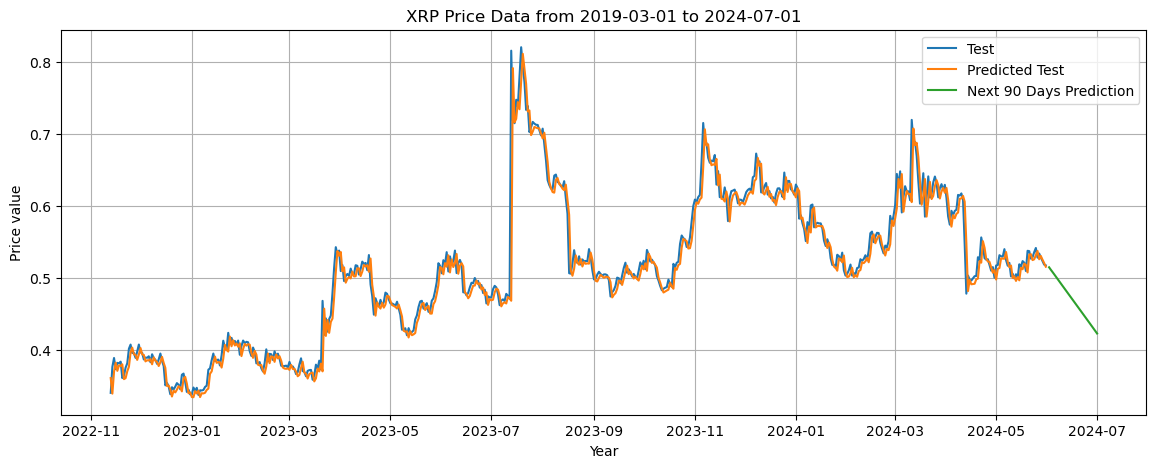

In [2]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted XRP prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted XRP prices for the next 60 days:
[0.51481466 0.51156738 0.50850003 0.50537878 0.50222148 0.49904961
 0.49587549 0.49270425 0.48953757 0.48637475 0.48321451 0.48005685
 0.47690135 0.47374765 0.47059496 0.46744295 0.46429102 0.46113866
 0.45798529 0.45483034 0.45167342 0.44851392 0.44535137 0.44218518
 0.43901491 0.43583997 0.43265997 0.42947419 0.42628223 0.42308355
 0.41987753 0.41666373 0.41344159 0.41021056 0.40697016 0.40371977
 0.40045887 0.39718694 0.39390332 0.3906075  0.38729899 0.3839771
 0.38064131 0.37729107 0.37392568 0.37054456 0.36714719 0.36373286
 0.36030098 0.35685092 0.35338198 0.34989356 0.34638499 0.34285566
 0.33930472 0.3357316  0.33213556 0.32851588 0.32487183 0.32120264]


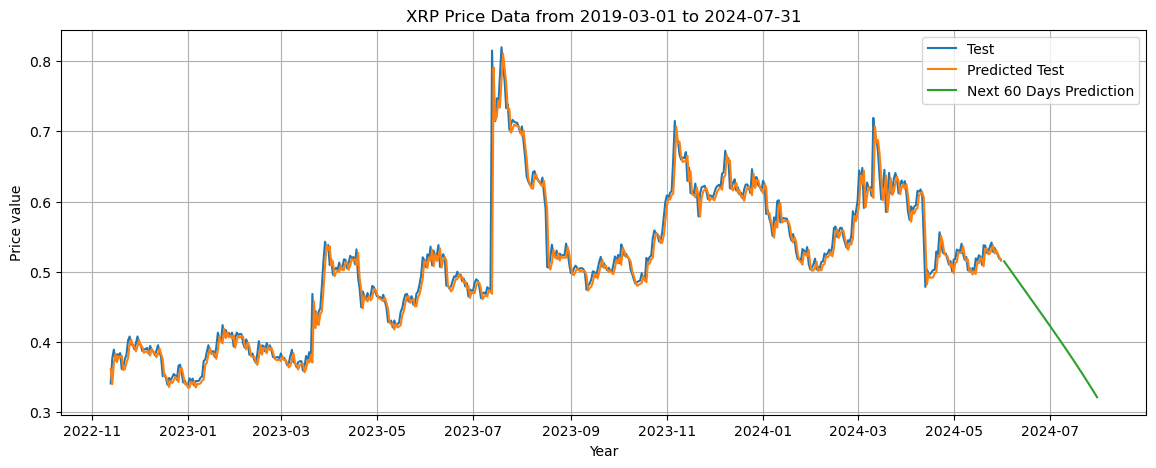

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted XRP prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted XRP prices for the next 90 days:
[0.51481466 0.51156738 0.50850003 0.50537878 0.50222148 0.49904961
 0.49587549 0.49270425 0.48953757 0.48637475 0.48321451 0.48005685
 0.47690135 0.47374765 0.47059496 0.46744295 0.46429102 0.46113866
 0.45798529 0.45483034 0.45167342 0.44851392 0.44535137 0.44218518
 0.43901491 0.43583997 0.43265997 0.42947419 0.42628223 0.42308355
 0.41987753 0.41666373 0.41344159 0.41021056 0.40697016 0.40371977
 0.40045887 0.39718694 0.39390332 0.3906075  0.38729899 0.3839771
 0.38064131 0.37729107 0.37392568 0.37054456 0.36714719 0.36373286
 0.36030098 0.35685092 0.35338198 0.34989356 0.34638499 0.34285566
 0.33930472 0.3357316  0.33213556 0.32851588 0.32487183 0.32120264
 0.31750754 0.3137858  0.31003657 0.30625906 0.3024525  0.29861599
 0.29474867 0.2908497  0.28691817 0.2829531  0.27895368 0.27491885
 0.27084766 0.26673912 0.26259219 0.25840586 0.25417899 0.24991051
 0.24559931 0.24124423 0.23684408 0.23239765 0.22790368 0.22336091
 0.21876803 0.214123

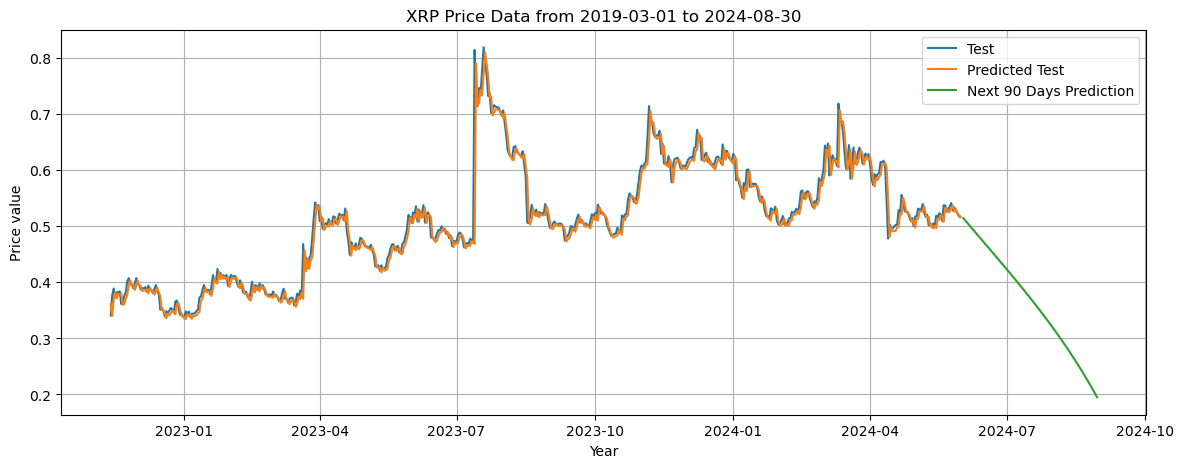

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted XRP prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()